In [12]:
import sacpy as scp
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import sacpy.Map

In [13]:
time1 = "1980-01"
time2 = "2018-12"
data_path = "../../DATA/ncep2_180x90/"

uw = xr.open_dataset(data_path + "uwnd.10m.mon.mean.nc")['uwnd']
vw = xr.open_dataset(data_path + "vwnd.10m.mon.mean.nc")['vwnd']
sst = xr.open_dataset("../../DATA/HadISST_sst_2x2.nc")['sst']
qa = xr.open_dataset(data_path + "shum.2m.mon.mean.nc")['shum']
slp = xr.open_dataset("../../DATA/slp.mon.mean.2x2.nc")['slp']

get_sp = lambda data: data.loc[{"lon": slice(120, 280), "lat": slice(-30,70 ), "time": slice(time1, time2)}]

uw, vw, sst, qa,slp = map(get_sp, [uw, vw, sst, qa,slp])
# qa = (0.972*sst - 8.92)*0.001

uw['time'],vw['time'],qa['time'],slp['time'] = [sst.time]*4

uw,vw,qa = map(lambda data:data.drop('level'),[uw,vw,qa])
# uw,vw = map(lambda data:data.drop('level'),[uw,vw])
qs = 6.11 * 10**(7.5 * sst / (sst + 237.3))
qs = 0.622 * qs / (1013. - 0.378 * qs)

uwa, vwa, ssta, qaa,qsa,slpa = map(lambda data: scp.get_anom(data), [uw, vw, sst, qa,qs,slp])
uwm, vwm, sstm, qam,qsm = map(lambda data: data.groupby("time.month").mean(), [uw, vw, sst, qa,qs])


In [14]:
roua = 1.225  # kg/m^3
Ce = 1.1e-3 # 
Lv = 2.5e6 # J/kg

In [15]:
ssta_eof = ssta.loc[:, -20:30, 150:275]
eof = scp.EOF(np.array(ssta_eof))
eof.solve()
pc = -eof.get_pc(npt=3)
pt = -eof.get_pt(npt=3)
sst_pt = ssta.loc[:,-30:70,120:280]
ssta_lr = scp.LinReg(pc[1],sst_pt)
pmm_region = ssta_lr.slope > 0.17
pmm_region[pmm_region.lat<=5] = False 
pmm_region[pmm_region.lat>=30] = False 
pc_mam_xr = xr.DataArray(pc[1],coords={"time":ssta_eof.time})
# plt.contourf(pt[1])

In [16]:
def term1_cal(ua, va, um, vm, qsm, qam):
    speed0 = ((vm+va)**2 + (um+va)**2)**0.5
    speed = ((vm)**2 + (um)**2)**0.5
    speed = xr.where(speed > 1.5,speed,1.5)
    res = -roua * Ce * Lv * (ua * um + va * vm) / speed * (qsm - qam)
    # res = -roua * Ce * Lv * (speed0 - speed) * (qsm - qam)
    return res
def term2_cal(um,vm,qsa,qaa):
    res = -roua * Ce * Lv * (vm**2 + um**2)**0.5 * (qsa - qaa) 
    return res
def term3_cal(ua, va,um,vm,qsa,qaa):
    speed = ((vm+va)**2 + (um+va)**2)**0.5
    speed = ((vm)**2 + (um)**2)**0.5
    speed = xr.where(speed > 1.5,speed,1.5)
    res = -roua * Ce * Lv * (ua * um + va * vm) / speed * (qsa - qaa)
    return res







In [17]:
ua_dc = {}
va_dc = {}
qsa_dc = {}
qaa_dc = {}

month_ls = [[1,2,3],[7,8,9]]
month_ls1 = [[3,4,5],[9,10,11]]
all_dict = {}
wind_dict = {}
for idx in [0,1]:
    month = month_ls[idx]
    month1 = month_ls1[idx]
    pmm_idx = scp.spec_moth_dat(pc_mam_xr,month1)
    uwa1, vwa1, ssta1, qaa1,qsa1,slpa1 = map(lambda data:scp.spec_moth_dat(data,month),
            [uwa, vwa, ssta, qaa,qsa,slpa])
    uwm1, vwm1, sstm1, qam1,qsm1 = map(lambda data: data[data.month.isin(month)].mean(axis=0),
                [uwm, vwm, sstm, qam,qsm])
    qam1,qsm1 = map(lambda data: data[data.month.isin([3,4,5])].mean(axis=0),
                [qam,qsm])
    uwa2, vwa2, ssta2, qaa2,qsa2,slpa2=map(lambda data: scp.LinReg(pmm_idx,data).slope,
                [uwa1, vwa1, ssta1, qaa1,qsa1,slpa1])
    term1 = term1_cal(uwa2,vwa2,uwm1,vwm1,qsm1,qam1)
    term2 = term2_cal(uwm1,vwm1,qsa2,qaa2)
    term3 = term3_cal(uwa2,vwa2,uwm1,vwm1,qsa2,qaa2)
    all_dict[idx] = [term1,term2,term3]
    wind_dict[idx] = [uwa2,vwa2,qsa2-qaa2,slpa2]

    

In [18]:
import cmaps
from matplotlib import colors
cmap1 = cmaps.cmp_b2r
fig = plt.figure(figsize=[12,7])
lhf_levels = np.linspace(-12,12,15)
abcd = ['a','b','c','d','e','f','g']
title = ["MAM","SON"]
reg_mean_ls = []
for i in range(6):
    idx = i //3
    idx1 = i % 3
    reg_mean = xr.where(pmm_region,all_dict[idx][idx1][0],np.NAN).mean()
    reg_mean_ls.append(reg_mean.data)


<Figure size 1200x700 with 0 Axes>

In [19]:
table = np.array(reg_mean_ls).reshape(2,3)
table = np.hstack([table,table.sum(axis=1)[...,np.newaxis]])

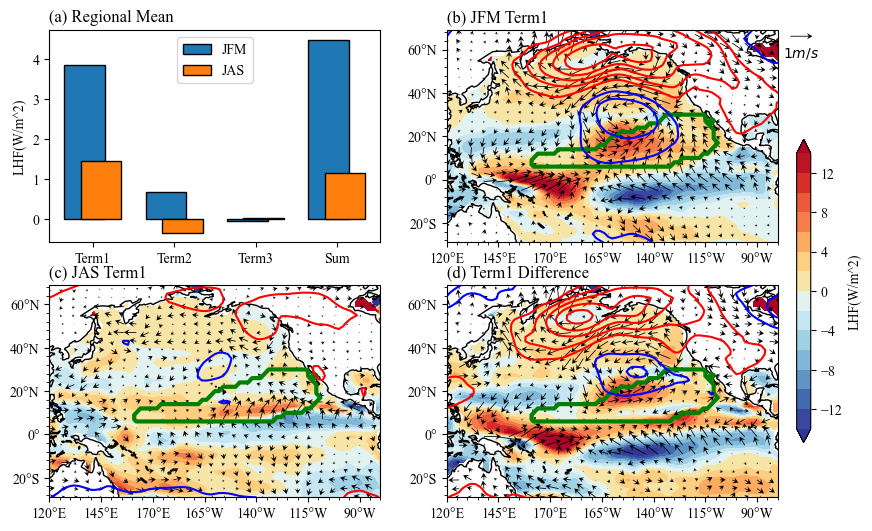

In [30]:
fig = plt.figure(figsize=[12/1.5+1.4, 7/1.5+1.4])

hw = 8
hl = 7
stepy = 20

cmap = colors.ListedColormap(['blue',"none", 'red'])
# cmap1 = cmaps.cmp_b2r
bounds=[-1e10,-1e-5,1e-5,1e10]
norm = colors.BoundaryNorm(bounds, cmap.N)
lhf_levels = np.linspace(-14,14,15)
title = ["JFM","JAS"]

ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
m = ax.scontourf(ssta.lon, ssta.lat, all_dict[0][0][0], levels=lhf_levels, cmap=cmap1)
ax.init_map(stepy=stepy)
ax.scontour(pmm_region.lon, pmm_region.lat, pmm_region, levels=[0.5], colors="green", linewidths=3)
ax.scontour(ssta.lon, ssta.lat,wind_dict[0][-1],norm=norm,cmap=cmap,levels=np.arange(-5.6,4,0.4))
q = ax.squiver(ssta.lon, ssta.lat, wind_dict[0][0][0], wind_dict[0][1][0], stepx=3, stepy=2, scale=15,
               headwidth=hw,headlength=hl)
ax.set_title("({}) {}".format(abcd[1],title[0]+" Term1"),loc='left')
# =================================================================================================
ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
m = ax.scontourf(ssta.lon, ssta.lat, all_dict[1][0][0], levels=lhf_levels, cmap=cmap1)
ax.init_map(stepy=stepy)
ax.scontour(pmm_region.lon, pmm_region.lat, pmm_region, levels=[0.5], colors="green", linewidths=3)
q = ax.squiver(ssta.lon, ssta.lat, wind_dict[1][0][0], wind_dict[1][1][0], stepx=3, stepy=2, scale=15,
               headwidth=hw,headlength=hl)
ax.scontour(ssta.lon, ssta.lat,wind_dict[1][-1],norm=norm,cmap=cmap,levels=np.arange(-5.6,4,0.4))
ax.set_title("({}) {}".format(abcd[2],title[1]+" Term1"),loc='left')
# =================================================================================================
ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax.scontourf(ssta.lon, ssta.lat, all_dict[0][0][0] - all_dict[1][0][0], levels=lhf_levels, cmap=cmap1)
ax.scontour(pmm_region.lon, pmm_region.lat, pmm_region, levels=[0.5], colors="green", linewidths=3)
ax.squiver(ssta.lon,
           ssta.lat,
           wind_dict[0][0][0] - wind_dict[1][0][0],
           wind_dict[0][1][0] - wind_dict[1][1][0],
           stepx=3,
           stepy=2,
           scale=15,
           headwidth=hw,headlength=hl)
ax.scontour(ssta.lon, ssta.lat,wind_dict[0][-1]-wind_dict[1][-1],norm=norm,cmap=cmap,levels=np.arange(-5.6,4,0.4))
ax.init_map(stepy=20)
ax.set_title("({}) {}".format(abcd[3],"Term1 Difference"),loc='left')
# =================================================================================================
ax = fig.add_subplot(2, 2, 1)
ax.bar(np.arange(4)-0.1,table[0],width=0.5,edgecolor="black",label="JFM")
ax.bar(np.arange(4)+0.1,table[1],width=0.5,edgecolor="black",label="JAS")
plt.xticks(np.arange(4),["Term1","Term2","Term3","Sum"])
ax.legend()
# plt.axhline(0,color="black")
ax.set_ylabel("LHF(W/m^2)")
ax.set_title("({}) {}".format(abcd[0],"Regional Mean"),loc='left')
# ==================================================================================================
ax.quiverkey(q, 0.925, 0.87, 1, r'$1 {m}/{s}$', labelpos='S',
              coordinates='figure')
ax_cb = fig.add_axes([0.92,0.2,0.015,0.5])
cb = fig.colorbar(m,cax=ax_cb,orientation="vertical", spacing="proportional")
cb.set_label("LHF(W/m^2)")
plt.savefig("./pic/Fig3.png",dpi=300)